In [1]:
import collections

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import numpy as np

import curiosidade


%load_ext autoreload
%autoreload 2

/media/nvme/prober/venvs/py3.9.10/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Torch setup

In [2]:
loss_fn = torch.nn.CrossEntropyLoss()

rnd_state = np.random.RandomState(8)
torch.random.manual_seed(32)

n, m = 400, 4
X = torch.from_numpy(rnd_state.randn(n, m)).float()
y = X.mean(axis=1).round().abs().long()

train_size = int(0.9 * n)
eval_size = int(0.05 * n)
test_size = n - train_size - eval_size

df = torch.utils.data.TensorDataset(X, y)
df_train, df_eval, df_test = torch.utils.data.random_split(
    df, lengths=[train_size, eval_size, test_size],
)

probing_dataloader_train = torch.utils.data.DataLoader(
    df_train,
    batch_size=10,
    shuffle=True,
)

probing_dataloader_eval = torch.utils.data.DataLoader(
    df_eval,
    batch_size=10,
    shuffle=False,
)

probing_dataloader_test = torch.utils.data.DataLoader(
    df_test,
    batch_size=10,
    shuffle=False,
)

num_cls = y.unique().numel()
X.shape, y.shape, num_cls

(torch.Size([400, 4]), torch.Size([400]), 2)

In [3]:
class BaseModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.params = torch.nn.Sequential(
            collections.OrderedDict((
                ("lin1", torch.nn.Linear(X.shape[1], 15, bias=True)),
                ("relu1", torch.nn.ReLU(inplace=True)),
                ("lin2", torch.nn.Linear(15, 25, bias=True)),
                ("relu2", torch.nn.ReLU(inplace=True)),
                ("lin3", torch.nn.Linear(25, num_cls)),
            )),
        )
    
    def forward(self, X):
        return self.params(X)
    
    
class ProbingModel(torch.nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        self.params = torch.nn.Sequential(
            torch.nn.Linear(input_dim, num_cls, bias=True),
        )
    
    def forward(self, X):
        return self.params(X)

In [4]:
base_model = BaseModel()
optim_base = torch.optim.Adam(base_model.parameters(), lr=0.01)

beta = 0.9
mov_avg_loss = 0.0

base_model = base_model.train()
for _ in range(50):
    for X_batch, y_batch in probing_dataloader_train:
        optim_base.zero_grad()
        y_logits = base_model(X_batch)
        loss = loss_fn(input=y_logits, target=y_batch)
        loss.backward()
        optim_base.step()
        mov_avg_loss = beta * mov_avg_loss + (1.0 - beta) * float(loss.cpu().detach().item())
    
    print(f"{mov_avg_loss=:.3f}")

mov_avg_loss=0.534
mov_avg_loss=0.257
mov_avg_loss=0.148
mov_avg_loss=0.125
mov_avg_loss=0.085
mov_avg_loss=0.118
mov_avg_loss=0.089
mov_avg_loss=0.062
mov_avg_loss=0.072
mov_avg_loss=0.084
mov_avg_loss=0.127
mov_avg_loss=0.088
mov_avg_loss=0.052
mov_avg_loss=0.057
mov_avg_loss=0.051
mov_avg_loss=0.039
mov_avg_loss=0.043
mov_avg_loss=0.055
mov_avg_loss=0.032
mov_avg_loss=0.063
mov_avg_loss=0.036
mov_avg_loss=0.040
mov_avg_loss=0.031
mov_avg_loss=0.062
mov_avg_loss=0.044
mov_avg_loss=0.051
mov_avg_loss=0.032
mov_avg_loss=0.042
mov_avg_loss=0.024
mov_avg_loss=0.029
mov_avg_loss=0.088
mov_avg_loss=0.055
mov_avg_loss=0.039
mov_avg_loss=0.040
mov_avg_loss=0.063
mov_avg_loss=0.036
mov_avg_loss=0.027
mov_avg_loss=0.035
mov_avg_loss=0.016
mov_avg_loss=0.037
mov_avg_loss=0.040
mov_avg_loss=0.029
mov_avg_loss=0.079
mov_avg_loss=0.087
mov_avg_loss=0.046
mov_avg_loss=0.022
mov_avg_loss=0.016
mov_avg_loss=0.020
mov_avg_loss=0.059
mov_avg_loss=0.020


## Curiosidade setup

In [9]:
import functools

task = curiosidade.ProbingTaskCustom(
    probing_dataloader_train=probing_dataloader_train,
    probing_dataloader_eval=probing_dataloader_eval,
    probing_dataloader_test=probing_dataloader_test,
    loss_fn=loss_fn,
    task_name="debug_task",
)

probing_factory = curiosidade.ProbingModelFactory(
    probing_model_fn=ProbingModel,
#     optim_fn=functools.partial(torch.optim.Adam, lr=0.001),
    task=task,
)

prober = curiosidade.core.attach_probers(
    base_model=base_model,
    probing_model_factory=probing_factory,
    modules_to_attach="relu\d+",
    modules_input_dim={
        "relu1": 15,
        "relu2": 25,
    },
    random_seed=16,
)

probing_res = prober.train(
    num_epochs=100,
    gradient_accumulation_steps=2,
    agg_epoch_metrics_fn=np.mean,
)

prober

ProbingModelContainer:
(a): Base model: BaseModel(
  (params): Sequential(
    (lin1): Linear(in_features=4, out_features=15, bias=True)
    (relu1): ReLU(inplace=True)
    (lin2): Linear(in_features=15, out_features=25, bias=True)
    (relu2): ReLU(inplace=True)
    (lin3): Linear(in_features=25, out_features=2, bias=True)
  )
)
(b): Task name: debug_task
(c): Probing datasets:
  (train):   36 batches of size (at most) 10.
  (eval) :    2 batches of size (at most) 10.
  (test) :    2 batches of size (at most) 10.
(d): Probed modules (2 in total):
  (0): params.relu1
  (1): params.relu2

In [10]:
prober.probed_modules

('params.relu1', 'params.relu2')

In [11]:
probing_res

ProbingResults(
    train = dict with modules ('params.relu1', 'params.relu2') and 100 values each,
    eval  = dict with modules ('params.relu1', 'params.relu2') and 100 values each,
    test  = dict with modules ('params.relu1', 'params.relu2') and 2 values each,
)

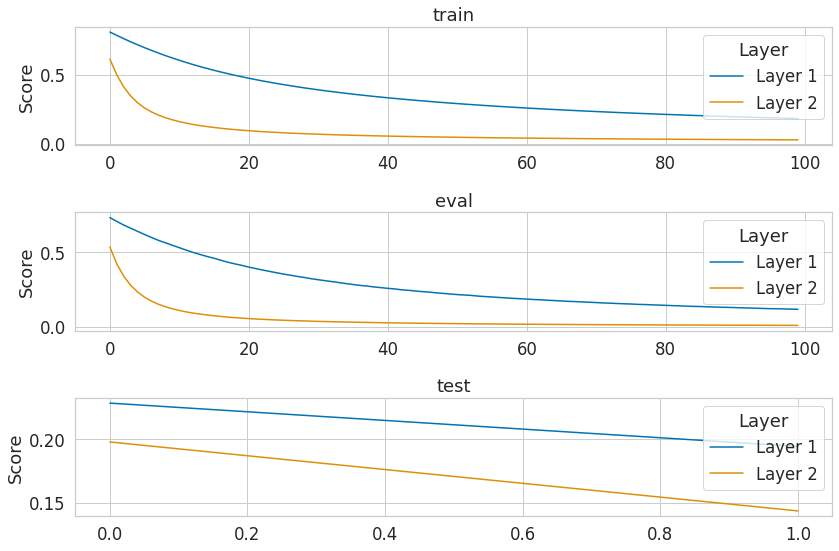

In [13]:
def create_plot(data, ax, split):
    df = pd.DataFrame.from_dict(data)

    ax.set_title(split)
    
    df = pd.DataFrame(np.vstack((
        list(zip(df.shape[0] * ["Layer 1"], df.iloc[:, 0])),
        list(zip(df.shape[0] * ["Layer 2"], df.iloc[:, 1])),
    )), columns=["Layer", "Score"])

    df["Score"] = df["Score"].astype(float)
    sns.lineplot(x=df.index % (df.shape[0]//2), y="Score", hue="Layer", data=df, ax=ax);

    
sns.set_theme(
    context="notebook",
    style="whitegrid",
    font_scale=1.5,
    palette="colorblind",
)

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12, 8))

create_plot(probing_res.train, ax=ax1, split="train")
create_plot(probing_res.eval, ax=ax2, split="eval")
create_plot(probing_res.test, ax=ax3, split="test")

plt.tight_layout()

## Test with BERT

In [28]:
import transformers

transformer_model = transformers.BertForTokenClassification.from_pretrained(
    "../../segmentador/pretrained_segmenter_model/2_6000_layer_model/"
)

transformer_model

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(6000, 768, padding_idx=0)
      (position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [23]:
import datasets

data = datasets.Dataset.load_from_disk(
    "../../segmentador/data/df_tokenized_split_0_120000_6000/eval/"
).shard(num_shards=15, index=0)

def fn_pad(item):
    new_item = {}
    for k, v in item.items():
        if k != "labels":
            new_item[k] = v + (1024 - len(v)) * [0]

    total_segments = sum(lab == 1 for lab in item["labels"])
    
    if total_segments > 20:
        new_label = 0
    elif 20 >= total_segments > 10:
        new_label = 1
    else:
        new_label = 2
    
    new_item["labels"] = new_label
            
    return new_item

num_cls = 3

data = data.map(fn_pad)
data.set_format("torch")
df_train, aux = data.train_test_split(test_size=0.1, shuffle=True).values()
df_eval, df_test = aux.train_test_split(test_size=0.5, shuffle=False).values()
df_train, df_eval, df_test

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 958/958 [00:00<00:00, 1429.48ex/s]


(Dataset({
     features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 862
 }),
 Dataset({
     features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 48
 }),
 Dataset({
     features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 48
 }))

In [24]:
class ProbingModel(torch.nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        self.params = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 128),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(128, num_cls),
        )
    
    def forward(self, X):
        out = X
        out, _ = out.max(axis=1)
        out = self.params(out)
        return out

In [25]:
probing_dataloader_train = torch.utils.data.DataLoader(
    df_train,
    batch_size=16,
    shuffle=True,
)

probing_dataloader_eval = torch.utils.data.DataLoader(
    df_eval,
    batch_size=16,
    shuffle=False,
)

probing_dataloader_test = torch.utils.data.DataLoader(
    df_test,
    batch_size=16,
    shuffle=False,
)

In [29]:
import functools

loss_fn = torch.nn.CrossEntropyLoss()

task = curiosidade.ProbingTaskCustom(
    probing_dataloader_train=probing_dataloader_train,
    probing_dataloader_eval=probing_dataloader_eval,
    probing_dataloader_test=probing_dataloader_test,
    loss_fn=loss_fn,
    task_name="debug_task_bert",
)

probing_factory = curiosidade.ProbingModelFactory(
    task=task,
    probing_model_fn=ProbingModel,
    optim_fn=functools.partial(torch.optim.Adam, lr=0.005),
)

prober = curiosidade.core.attach_probers(
    base_model=transformer_model,
    probing_model_factory=probing_factory,
    modules_to_attach="bert.encoder.layer.\d+.output.dense",
    device="cuda",
)

prober

ProbingModelContainer:
(a): Base model: BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(6000, 768, padding_idx=0)
      (position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [30]:
probing_res = prober.train(
    num_epochs=3,
    show_progress_bar=True,
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:33<00:00,  1.59it/s]


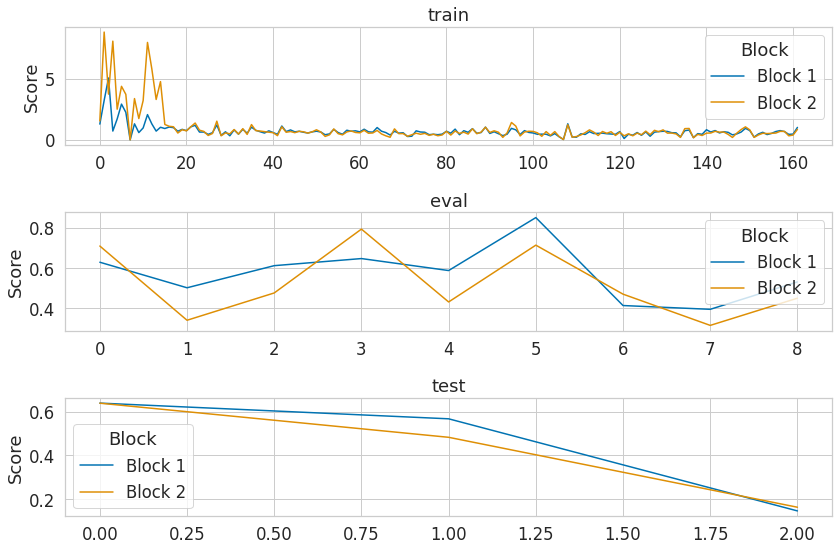

In [39]:
def create_plot(data, ax, split):
    df = pd.DataFrame.from_dict(data)

    ax.set_title(split)
    
    df = pd.DataFrame(np.vstack((
        list(zip(df.shape[0] * ["Block 1"], df.iloc[:, 0])),
        list(zip(df.shape[0] * ["Block 2"], df.iloc[:, 1])),
    )), columns=["Block", "Score"])

    df["Score"] = df["Score"].astype(float)
    sns.lineplot(x=df.index % (df.shape[0]//2), y="Score", hue="Block", data=df, ax=ax);

    
sns.set_theme(
    context="notebook",
    style="whitegrid",
    font_scale=1.5,
    palette="colorblind",
)

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12, 8))

create_plot(probing_res.train, ax=ax1, split="train")
create_plot(probing_res.eval, ax=ax2, split="eval")
create_plot(probing_res.test, ax=ax3, split="test")

plt.tight_layout()